Learning with Prototypes
---

We have a data of 4096 features (extracted from a deep learning model). Our task is to predict the class labels of the unseen datapoints.

1. We start off by first looking at the data
2. Then we compute the means of the 40 seen classes as $\mu_k$

In [1]:
import numpy as np
import pickle as p

Loading the data and looking at the datashape

In [2]:
X_seen=np.load('X_seen.npy', allow_pickle=True, encoding='bytes')

Xtest=np.load('AwA_python/Xtest.npy')
Ytest=np.load('AwA_python/Ytest.npy')

class_attributes_seen=np.load('AwA_python/class_attributes_seen.npy')
class_attributes_unseen=np.load('AwA_python/class_attributes_unseen.npy')

print(f'''
X_seen:                     {X_seen.shape}
Xtest:                      {Xtest.shape}
Ytest:                      {Ytest.shape}
class_attributes_seen:      {class_attributes_seen.shape}
class_attributes_unseen:    {class_attributes_unseen.shape}
''')


X_seen:                     (40,)
Xtest:                      (6180, 4096)
Ytest:                      (6180, 1)
class_attributes_seen:      (40, 85)
class_attributes_unseen:    (10, 85)



## Method 1
**Steps**
1. Compute the mean of each seen class.
2. Compute the similarity (dot product based) of each unseen class with each of the seen classes.
3. Normalize the similarity vector (to that it sums to 1, since we are using a convex combination).
4. Compute the mean of each unseen class using a convex combination of means of seen classes.
5. Apply the model to predict labels on unseen class test inputs.
6. Compute classification accuracies.

Computing the means of seen classes

In [3]:
means_seen = np.array([row.mean(axis=0) for row in X_seen])
means_seen.shape

(40, 4096)

Computing the similarity between the seen and unseen classes by taking a dot product between the vectors for each class.

Here we are taking the matrix multiplication of `class_attributes_unseen` of shape `(10, 85)` and `class_attributes_seen.T` of shape `(85, 40)`, which gives us a matrix of shape `(10, 40)`, where each row contains the similarity vector of that unseen class with the seen classes.

In [4]:
# Computing similarity between seen and unseen classes

similarities = class_attributes_unseen@class_attributes_seen.T
similarities.shape

(10, 40)

To compute the weighted sum of the means to find the means of the unseen classes we have to normalize the above obtain similarity vectors.

In [5]:
# Normalizing the similarity vector to 1
sums = np.sum(similarities, axis=1)
norm_similarities = np.array([similarity/sum_val for similarity, sum_val in zip(similarities, sums)])
norm_similarities.shape

(10, 40)

Now we estimate the measn of the unseen classes by taking a weighted sum of the `norm_similarities` with `means_seen`

In [6]:
# Computing means of unseen classes using convex combination of means of the seen classes.
means_unseen = norm_similarities@means_seen
means_unseen.shape

(10, 4096)

### Predict
Generating predictions based on the unseen classes on `Xtest` and comparing the same to `Ytest` to calculate accuracy

In [7]:
def predict(means, test_input):
    distances = np.array([(test_input - mean).T@(test_input - mean) for mean in means])
    return np.argmin(distances)+1.0

predictions = np.array([predict(means_unseen, test_point) for test_point in Xtest]).reshape(-1, 1)
predictions.shape


(6180, 1)

Computing the accuracy score

In [8]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(Ytest, predictions)

print(f'Accuracy = {acc*100:.3f}%')

Accuracy = 46.893%


## Method 2
**Steps**
1. Compute the mean of each seen class.
2. Learn the multi-output regression model with class attribute vector being the input and the class mean vector being the output (this will use the seen class attributes and their mean vectors).
3. Apply the learned regression model to compute the mean of each unseen class.
4. Apply the model to predict labels on unseen class test inputs.
5. Compute classification accuracies.

Note: You need to try several values of the regularization hyperparameter $\lambda$

In [9]:
# Computing the means
means_seen = np.array([row.mean(axis=0) for row in X_seen])
means_seen.shape

(40, 4096)

In [10]:
X = class_attributes_seen
y = means_seen
lambd = 1 * np.eye(85)
weights = np.linalg.inv(X.T@X + lambd)@X.T@y
weights.shape

(85, 4096)

In [11]:
means_unseen = class_attributes_unseen@weights
means_unseen.shape

(10, 4096)

In [12]:
def predict(means, test_input):
    distances = np.array([(test_input - mean).T@(test_input - mean) for mean in means])
    return np.argmin(distances)+1.0

predictions = np.array([predict(means_unseen, test_point) for test_point in Xtest]).reshape(-1, 1)
predictions.shape

(6180, 1)

In [13]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(Ytest, predictions)

print(f'Accuracy = {acc*100:.3f}%')

Accuracy = 67.395%


In [14]:
# Putting it all together to get a graph
accuracies = []
X = class_attributes_seen
y = means_seen
lambdas = [0.01, 0.1] + list(np.arange(0.5, 10, 0.5)) + [10, 20, 50, 100]
max_accuracy = -1
optimal_lambda = 0
for l in lambdas:
    lambd = l * np.eye(85)
    weights = np.linalg.inv(X.T@X + lambd)@X.T@y
    means_unseen = class_attributes_unseen@weights
    predictions = np.array([predict(means_unseen, test_point) for test_point in Xtest]).reshape(-1, 1)
    acc = accuracy_score(Ytest, predictions)
    accuracies.append(acc)
    if(acc>max_accuracy):
        max_accuracy = acc
        optimal_lambda = l

accuracies = np.array(accuracies)

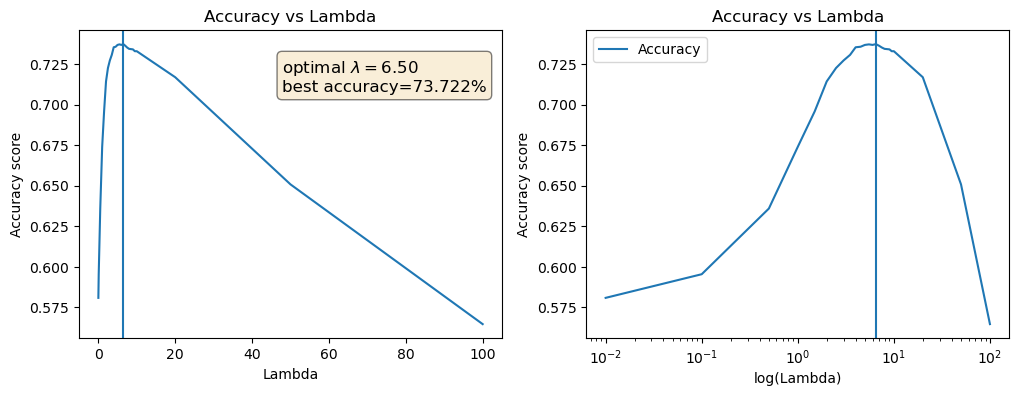

In [28]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(lambdas, accuracies, label='Accuracy')
ax[0].axvline(x=optimal_lambda)
ax[0].set_title('Accuracy vs Lambda')
ax[0].set_xlabel('Lambda')
ax[0].set_ylabel('Accuracy score')

ax[1].plot(lambdas, accuracies, label='Accuracy')
ax[1].axvline(x=optimal_lambda)
ax[1].set_title('Accuracy vs Lambda')
ax[1].set_xlabel('log(Lambda)')
ax[1].set_xscale('log')
ax[1].set_ylabel('Accuracy score')

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax[0].text(0.48, 0.8, r'optimal $\lambda=%.2f$'%optimal_lambda + '\n' + 'best accuracy=%.3f%%'%(max_accuracy*100), transform=ax[0].transAxes, fontsize=12, bbox=props)
plt.legend()

In [16]:
optimal_lambda

6.5

In [15]:
lambdas

[0.01,
 0.1,
 0.5,
 1.0,
 1.5,
 2.0,
 2.5,
 3.0,
 3.5,
 4.0,
 4.5,
 5.0,
 5.5,
 6.0,
 6.5,
 7.0,
 7.5,
 8.0,
 8.5,
 9.0,
 9.5,
 10,
 20,
 50,
 100]